# Sequence mapping and clustering

A common need in bioinformatics is, given a number of *query* sequences, group them based on their similarity either to one another, or their similarity to sequences in an external reference database, or to both. The most common way to do this is using sequence alignment (you may be noticing a theme here...).

The process of searching a set of sequences against a reference database to find their best match is typically referred to a **sequence mapping**. One example of this would be in *genome re-sequencing*. If you're searching for polymorphisms in the human genome that may be associated with a phenotype (e.g., a particular disease) you might begin by sequencing the full human genome. Because the human genome has been fully sequenced and (mostly) assembled, you could map your short sequence reads against the full human genome, and then search for loci (or co-located sets of one or more bases) that vary with the phenotype of interest. Because this process is generally performed with DNA sequencing reads, you may also hear it referred to as *read mapping*.

A similar process can be applied if there is no reference database to search against. In this case, sequences will be grouped together based on their similarity to one another. This is most often applied to reads of a single gene or locus across the genomes of many different organisms. This process is referred to as **de novo sequence clustering**, and one field where this is common is **microbiomics**, or the study of whole communities of microorganisms. Because we don't know how to culture the vast majority of microbes, most of what we know about the composition of microbial communities (e.g., in free-living environments, such as the ocean, soil, or surfaces in our homes or offices, or in host-associated environments, such as the human gut) is based on sequencing specific marker genes such as the 16S rRNA from all community members. If we obtain a large number of sequence reads, many of the things we want to do with them (such as identify their taxonomic origin, or understand where they fall in a phylogenetic tree) is too computationally intensive to achieve. So instead, we group sequences that are identicial or highly similar in composition into **Operational Taxonomic Units (OTUs)**, and we choose a single representative of that OTU to work with downstream. For example, if we have a group of 16S rRNA reads that are within 97% identity to one member of that cluster (the cluster centroid) we may assume that the taxonomic origin of the cluster centroid is the same as the taxonomic origin of all of the sequences in the group. This is an *assumption* - it may or may not be true - but it is a necessary evil given the current technology. 

Another application of grouping similar sequences (or **OTU clustering**, or **OTU picking**, as it is sometimes referred to) is in grouping sequences in a database before investigating them, to reduce taxonomic bias in the database. For example, *E. coli* is one of the most heavily sequenced microbes. If you're interested in understanding the frequency of variants of a specific gene across a range of microbial diversity, you might begin by obtatining all sequences of that gene from [GenBank](https://www.ncbi.nlm.nih.gov/genbank/). Because there may be many more *E. coli* sequences, purely because of sequencing bias, you'd likely want to group your sequences into OTUs before computing variant frequencies, so your calculations are not biased toward the frequencies in *E. coli*, as hundreds of E. coli sequences would likely group to one or a few closely related OTUs. In other words, you're trying to find a **divergent set** of sequences to work with (and an [aptly named tool](http://www.ncbi.nlm.nih.gov/pubmed/16769708) was published in 2006 to automate this process).

We have learned the key tools we need for both sequence mapping and clustering in previous chapters. **Because the process of read mapping is nearly identical to database searching, in this chapter we'll start by exploring how to perform de novo sequence clustering**. At the end of the chapter we'll look at a case where we combine sequence clustering with sequence mapping, which arose to deal with massive sequence datasets generated in microbiomics.

In [1]:
%pylab inline

from __future__ import print_function, division
import matplotlib.pyplot as plt
from IPython.core import page
page.page = print
import networkx as nx
import pandas as pd
from skbio import BiologicalSequence, DNA, Alignment
from skbio.alignment import SequenceCollection
from skbio.parse.sequences import parse_fasta
from skbio.alignment import local_pairwise_align_ssw, global_pairwise_align_nucleotide

Populating the interactive namespace from numpy and matplotlib


## *De novo* clustering of sequences by similarity 

The algorithm at the core of *de novo* clustering is sequence alignment. In an ideal world, we would perform a full multiple sequence alignment of all of our sequences, compute their pairwise similarities (or dissimilarities), and use those values to group sequences that are above some *similarity threshold* into *OTU clusters* (just *OTUs* from here). As we discussed in the mutliple sequence alignment chapter however, that is infeasible for more than a few tens of sequences due to computational and memory requirements. Even progressive alignment can't typically handle more than a few tens of thousands of sequences (at least with the currently available implementations, that I am aware of), so OTU clustering is generally acheived by picking pairs of sequences to align. You'll notice in this section that many of the heuristics that have been applied for speeding up database searching are similar to the heuristics applied for OTU clustering.

We'll work with SSW for Smith-Waterman pairwise alignment with affine gap scoring here, though in principle any pairwise aligner could be substituted. 

In [2]:
help(local_pairwise_align_ssw)

Help on built-in function local_pairwise_align_ssw in module skbio.alignment._ssw_wrapper:

local_pairwise_align_ssw(...)
    Align query and target sequences with Striped Smith-Waterman.
    
    Parameters
    ----------
    sequence1 : str or BiologicalSequence
        The first unaligned sequence
    sequence2 : str or BiologicalSequence
        The second unaligned sequence
    
    Returns
    -------
    ``skbio.alignment.Alignment``
        The resulting alignment as an Alignment object
    
    Notes
    -----
    This is a wrapper for the SSW package [1]_.
    
    For a complete list of optional keyword-arguments that can be provided,
    see ``skbio.alignment.StripedSmithWaterman``.
    
    The following kwargs will not have any effect: `suppress_sequences` and
    `zero_index`
    
    If an alignment does not meet a provided filter, `None` will be returned.
    
    References
    ----------
    .. [1] Zhao, Mengyao, Wan-Ping Lee, Erik P. Garrison, & Gabor T.
       Mart

<div style="float: right; margin-left: 30px;"><img style="float: right; margin-left: 30px;" src="files/images/cluster-legend.png" align=right></div>

In the figures that follow, points represent sequences. A line projecting from a point indicates a dissimilarity range from that sequence (e.g., 10% dissimilar). The circle defined by the point (sequence) and the line (dissimilarity range) define the space containing all sequences within a given dissimilarity threshold.

These illustrations are used to describe OTUs. When a circle or set of overlapping circles are filled with grey, that defines the space that a new sequence can fall in if it will be considered part of the OTU. In the the following sections we'll explore different ways that this can be defined.

*These figures attempt to illustrate several ideas about OTU clustering, but because the space that we're working in is two dimensional, we can't perfectly represent the process. These figures are useful as visual aid, but should not be considered mathematically robust.* 


Let's define a collection of sequences to work with. These are derived from the [Greengenes](http://greengenes.secondgenome.com/) [13_8](ftp://greengenes.microbio.me/greengenes_release/gg_13_5/) database, and we're pulling them from the [QIIME default reference project](https://github.com/biocore/qiime-default-reference). We can load these as a list of sequences using ``skbio.parse.sequences.parse_fasta``, and count them by taking the length of the list. For the sake of runtime, we'll work with only a small random subset these sequences.

**Our goal here will be to group these sequences into OTUs based on some similarity threshold that we define.** If we set this similarity threshold at 90%, meaning that the sequences within that OTU are 90% identicial (either to each other, or maybe to some representative of that cluster - we'll explore some variants on that definition below), we'd call these *90% OTUs*.  

In [3]:
from qiime_default_reference import get_reference_sequences 
from random import random

seqs_16s = []
fraction_to_keep = 0.001
for e in list(parse_fasta(get_reference_sequences())):
    if random() < fraction_to_keep:
        seqs_16s.append(BiologicalSequence(e[1], id=e[0]))
seqs_16s = SequenceCollection(seqs_16s)
print(seqs_16s.sequence_count())

99


In [4]:
def show_clusters(clusters, print_clusters=True, plot_clusters=True, plot_labels=False):
    G = nx.Graph()
    for c in clusters:
        G = nx.union(G, c)
        if print_clusters: print("%s: %s" % (c.graph['id'], [s.id for s in c.nodes()]))
    if plot_clusters:
        pos=nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos)
        if G.number_of_edges() > 0:
            nx.draw_networkx_edges(G, pos)
        if plot_labels: nx.draw_networkx_labels(G, pos, labels={d:d.id for d in G.nodes()})
        _ = plt.axis('off')

### Furthest neighbor clustering

The first approach we'll look at is one that has been called *furthest neighbor*, because whether a sequence becomes a member of a cluster is defined by it's most dissimilar (furthest) "neighbor" in that cluster.

The way this algorithm works is that we start with our list of sequences. Because this is *de novo* clustering, by definition our first sequence is added to a new cluster (because there are no pre-existing clusters). We'll call this `OTU 1`. We then iterate over the remaining sequences. For the second sequence we compute its pairwise alignment with the first, followed by computing their percent similarity. If their percent similarity is greater than or equal to the similarity threshold, we add the second sequence to `OTU 1`. If is it less than the similarity threshold, we create a new OTU, `OTU 2`, and add the second sequence to that cluster. 

We continue iterating over the remaining sequences. For each sequence, we compute the pairwise similarity between that sequence and all sequences in each OTU. **If the percent similarity between a query sequence and *all* sequences in a given OTU (say OTU $x$ is greater than the similarity threshold, we add the sequence to OTU $x$.)** Otherwise we check the next OTU in the list. If this criteria is not met for any of the OTUs, then we define a new OTU to add the sequence to. 

Here's what that process would look like for these six sequences:

In [5]:
s1 = DNA('AAAAAAAAAA', 's1')
s2 = DNA('AAAAATTTTT', 's2')
s3 = DNA('AAAAAAACCA', 's3')
s4 = DNA('CCCCAATTTT', 's4')
s5 = DNA('ACCAAATTTT', 's5')
s6 = DNA('AGGAAAAAAA', 's6')

aln1 = Alignment([s1, s2, s3, s4, s5, s6])

Our first sequence, ``s1``, will define a new OTU. We'll call that OTU ``OTU 1``. We'll great a list of OTUs and add this as our first.

In [6]:
otus = []
G=nx.Graph(id="OTU 1")
G.add_node(s1)
otus.append(G)

Our second sequence, ``s2`` falls outside of the similarity threshold to ``S1``, it will also define a new OTU. We'll call that OTU ``OTU 2``.

In [7]:
print(s2.fraction_same(s1))

0.5


OTU 1: ['s1']
OTU 2: ['s2']


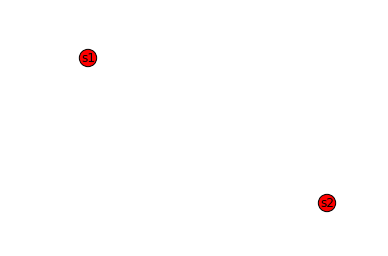

In [8]:
G=nx.Graph(id="OTU 2")
G.add_node(s2)
otus.append(G)
show_clusters(otus, plot_labels=True)

Now imagine that our third sequence, ``s3`` falls within the range of ``s1``. We'd cluster ``s3`` into ``OTU 1`` since it's within the similarity range of all of the sequences in ``OTU 1`` (for now that's just ``s1``). 

In [9]:
for i, otu in enumerate(otus, start=1):
    print(' '.join(["OTU %d" % i] + map(str,[s.fraction_same(s4) for s in otu])))

OTU 1 0.2
OTU 2 0.5


We now have three sequences clustered into two OTUs.

OTU 1: ['s1', 's3']
OTU 2: ['s2']


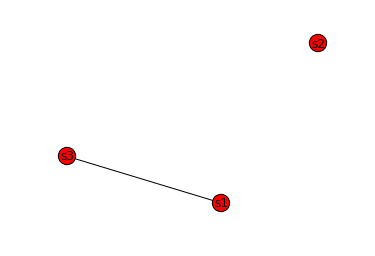

In [10]:
otus[0].add_edge(s1, s3)
show_clusters(otus, plot_labels=True)

Now let's cluster a fourth sequence, ``s4``. We find that this falls outside the range of ``OTU 1``, and also outside the range of ``OTU 2``. So, we'd create a new OTU, ``OTU 3``, containing ``s4``.

In [11]:
for i, otu in enumerate(otus, start=1):
    print(' '.join(["OTU %d" % i] + map(str,[s.fraction_same(s4) for s in otu])))

OTU 1 0.2 0.2
OTU 2 0.5


OTU 1: ['s1', 's3']
OTU 2: ['s2']
OTU 3: ['s4']


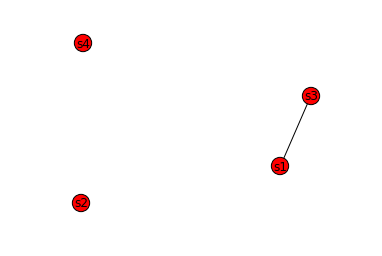

In [12]:
G=nx.Graph(id="OTU 3")
G.add_node(s4)
otus.append(G)
show_clusters(otus, plot_labels=True)

Next, let's cluster our fifth sequence, ``s5``. We find that this falls outside the range of ``OTU 1``, but inside the range of both ``OTU 2`` and ``OTU 3``. 

In [13]:
for i, otu in enumerate(otus, start=1):
    print(' '.join(["OTU %d" % i] + map(str,[s.fraction_same(s5) for s in otu])))

OTU 1 0.4 0.4
OTU 2 0.7
OTU 3 0.8


Algorithmically, we now have a choice to make. How do we decided which OTU a sequence should belong to if it is within the similarity range of several OTUs? 

A few choices would be:
 1. add it to the cluster where it first matches all sequences, 
 2. add it to the cluster where it has the smallest average distance to the cluster members, 
 3. or add it to the cluster with the most members. 

There are many other options as well. Let's choose the option 1 here, as it requires performing the fewest number of alignments, so should be fastest (we'll explore that in more detail soon). Our mapping of OTUs to sequences would look like:

OTU 1: ['s1', 's3']
OTU 2: ['s5', 's2']
OTU 3: ['s4']


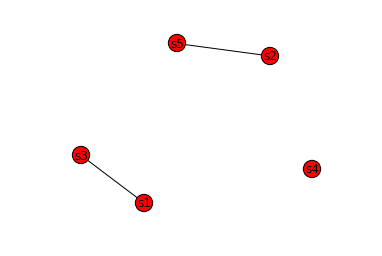

In [14]:
otus[1].add_edge(s2, s5)
show_clusters(otus, plot_labels=True)

Finally, let's cluster our last sequence, ``s6``. 

In [15]:
for i, otu in enumerate(otus, start=1):
    print(' '.join(["OTU %d" % i] + map(str,[s.fraction_same(s6) for s in otu])))

OTU 1 0.8 0.6
OTU 2 0.4 0.3
OTU 3 0.2


In this case, it falls within the similarity range of ``s1``, but outside of the similarity range of ``s3``. So, because our algortihm requires that a sequence be within the simiarity range of all sequences in an OTU, ``s6`` cannot be a member of ``OTU 1``, so instead it's assigned to a new OTU, ``OTU 4``. Our final mapping of OTUs to sequences would look like:

OTU 1: ['s1', 's3']
OTU 2: ['s5', 's2']
OTU 3: ['s4']
OTU 4: ['s6']


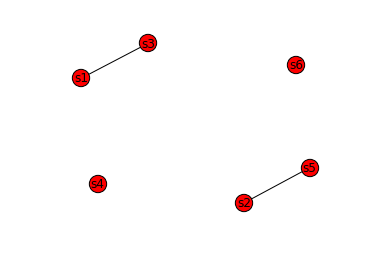

In [16]:
G=nx.Graph(id="OTU 4")
G.add_node(s6)
otus.append(G)
show_clusters(otus, plot_labels=True)

In [17]:
from numpy import mean

def further_neighbor_cluster_match(seq, cluster, similarity_threshold, aligner):
    alignment_results = []
    for node in cluster.nodes_iter():
        aln = aligner(seq, node)
        percent_similarity = aln[0].fraction_same(aln[1])
        alignment_results.append((node, percent_similarity))
        if percent_similarity < similarity_threshold:
            return False, alignment_results
    return True, alignment_results
            

def furthest_neighbor_cluster(seqs, similarity_threshold, aligner=local_pairwise_align_ssw):
    clusters = []
    num_alignments = 0
    for query_seq in seqs:
        clustered = False
        for cluster in clusters:
            clustered, alignment_results = further_neighbor_cluster_match(
                query_seq, cluster, similarity_threshold, aligner)
            num_alignments += len(alignment_results)
            if clustered:
                break
        if clustered:
            for n, s in alignment_results:
                cluster.add_edge(query_seq, n, percent_similarity=s)
        else:
            # create a new cluster containing only this node
            new_cluster = nx.Graph(id="OTU %d" % (len(clusters) + 1))
            new_cluster.add_node(query_seq)
            clusters.append(new_cluster)
    return clusters, num_alignments

10
OTU 1: ['s1', 's3']
OTU 2: ['s5', 's2']
OTU 3: ['s4']
OTU 4: ['s6']


/Users/caporaso/.virtualenvs/iab/lib/python2.7/site-packages/skbio/alignment/_pairwise.py:540: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


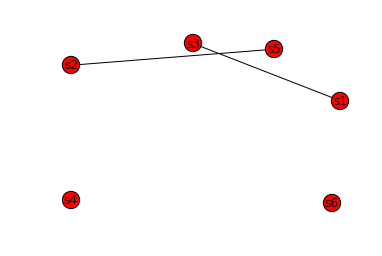

In [18]:
# Here we want our sequences to align from beginning to end (because they're toy examples)
# so we'll penalize terminal gaps.
from functools import partial 
global_pairwise_align_nucleotide = partial(global_pairwise_align_nucleotide, penalize_terminal_gaps=True)

clusters, num_alignments = furthest_neighbor_cluster([s1, s2, s3, s4, s5, s6], 0.70, aligner=global_pairwise_align_nucleotide)
print(num_alignments)
show_clusters(clusters, plot_labels=True)

Let's apply that function to our sequence collection. This function will return the number of pairwise alignments that were performed (it'll be clear why we're interested in that soon), and the OTUs. 

In [19]:
clusters, num_alignments = furthest_neighbor_cluster(seqs_16s, 0.70)
show_clusters(clusters, plot_clusters=False, plot_labels=False)

OTU 1: ['995155', '4379525', '298988', '6749']
OTU 2: ['877884', '243579', '82320', '327239', '694774', '730246', '4351185']
OTU 3: ['731639', '819699', '605566']
OTU 4: ['796969', '329302', '4433048', '4295874', '289174', '2931208', '251465', '164915']
OTU 5: ['694282', '181529', '277215']
OTU 6: ['572676', '4366868']
OTU 7: ['275123', '181568', '310877', '182729', '4479562', '571031', '303919', '314337', '331117', '276257']
OTU 8: ['566377', '181960', '167502']
OTU 9: ['551423', '322469', '1118300', '4417725', '4431461', '239717', '815314']
OTU 10: ['513370', '2532911', '730661', '4454871', '301867', '146275', '239868', '272591', '366311', '319497', '3427116', '885776']
OTU 11: ['4417417', '358664']
OTU 12: ['777102', '305957']
OTU 13: ['298922']
OTU 14: ['278960']
OTU 15: ['261892']
OTU 16: ['257001', '248801', '198774']
OTU 17: ['250445']
OTU 18: ['239787', '992327', '729865']
OTU 19: ['222734', '20793']
OTU 20: ['723052', '144260']
OTU 21: ['107418']
OTU 22: ['3984455', '104164']


Let's define a function that will be useful for exploring different clustering algorithms:

In [20]:
from time import time

def evaluate_cluster_fn(cluster_fn, seqs, similarity_threshold, display=True):
    start_time = time()
    clusters, num_alignments = cluster_fn(seqs, similarity_threshold)
    end_time = time()
    run_time = end_time - start_time
    num_clusters = len(clusters)
    if display:
        print("Number of alignments performed: %d" % num_alignments)
        print("Runtime: %1.3fs" % run_time)
        print("Number of clusters: %d" % num_clusters)
        print("Clusters:")
        show_clusters(clusters, plot_clusters=False, plot_labels=False)
    return num_alignments, run_time, num_clusters

Now let's apply that:

In [21]:
r = evaluate_cluster_fn(furthest_neighbor_cluster, seqs_16s, 0.70)

Number of alignments performed: 1458
Runtime: 6.188s
Number of clusters: 37
Clusters:
OTU 1: ['995155', '4379525', '298988', '6749']
OTU 2: ['877884', '243579', '82320', '327239', '694774', '730246', '4351185']
OTU 3: ['731639', '819699', '605566']
OTU 4: ['796969', '329302', '4433048', '4295874', '289174', '2931208', '251465', '164915']
OTU 5: ['694282', '181529', '277215']
OTU 6: ['572676', '4366868']
OTU 7: ['275123', '181568', '310877', '182729', '4479562', '571031', '303919', '314337', '331117', '276257']
OTU 8: ['566377', '181960', '167502']
OTU 9: ['551423', '322469', '1118300', '4417725', '4431461', '239717', '815314']
OTU 10: ['513370', '2532911', '730661', '4454871', '301867', '146275', '239868', '272591', '366311', '319497', '3427116', '885776']
OTU 11: ['4417417', '358664']
OTU 12: ['777102', '305957']
OTU 13: ['298922']
OTU 14: ['278960']
OTU 15: ['261892']
OTU 16: ['257001', '248801', '198774']
OTU 17: ['250445']
OTU 18: ['239787', '992327', '729865']
OTU 19: ['222734', '

### Nearest neighbor clustering

Let's try a variant on this algorithm. How would things change if **instead of requiring that a sequence be within the similarity treshold of all sequences in an OTU, we only required that it be within the similarity threshold of one sequence in that OTU**? This is referred to as **nearest neighbor** clustering, because cluster membership is defined by the percent similarity to the most similar (or *nearest*) "neighbor" in the cluster. 

Let's look at the process for six sequences again.

<img src="files/images/nearest-neighbor.1.png">

Our first sequence, $S1$, will again define a new OTU. We'll call that OTU $OTU1$ and start building our mapping of OTUs to the sequences they contain:

$OTU1$: $S1$ 

<hr>

<img src="files/images/nearest-neighbor.2.png">

Our second sequence, $S2$, still falls outside of the similarity threshold to $S1$, so will also define a new OTU. We'll call that OTU $OTU2$.

$OTU1$: $S1$

$OTU2$: $S2$

<hr>

<img src="files/images/nearest-neighbor.3.png">

Now imagine that our third sequence, $S3$ falls within the range of $OTU1$. We'd cluster $S3$ into $OTU1$ with $S1$. We now have three sequences clustered into two OTUs. So far, things are looking the same as before, except notice how our OTU definition (grey shading) is now different. Because any sequence within the similarity threshold of *any* of sequence in the OTU will fall into this OTU, the shading now covers the area covered by either of our sequences, rather than the area covered by both of our sequences (in set theory terminology, it is the *union* now, where previously it was the *intersection*). 

$OTU1$: $S1$ $S3$

$OTU2$: $S2$

<hr>

<img src="files/images/nearest-neighbor.4.png">

Now let's cluster a fourth sequence, $S4$. We find that this falls outside the range of $OTU1$, and (just barely) outside the range of $OTU2$. So, we'd create a new OTU, $OTU3$, containing $S4$.

$OTU1$: $S1$ $S3$

$OTU2$: $S2$

$OTU3$: $S4$

<hr>

<img src="files/images/nearest-neighbor.5.png">

Next, let's cluster our fifth sequence, $S5$. We find that this falls outside the range of $OTU1$, and inside the range of both $OTU2$ and $OTU3$. As with furthest neighbor, we have a choice of how to handle this. We'll again assign it to the cluster to which it is the most similar. Our mapping of OTUs to sequences would look like:

$OTU1$: $S1$ $S3$

$OTU2$: $S2$

$OTU3$: $S4$ $S5$

<hr>

<img src="files/images/nearest-neighbor.6.png">

Finally, let's cluster our last sequence, $S6$. Remember that $S6$ falls within the similarity range of $S1$, but outside of the similarity range of $S3$. In furthest neighbor, this meant that it was assigned to a new OTU, but with nearest neighbor it meets the inclusion criteria for $OTU1$. So, our final mapping of OTUs to sequences would look like:

$OTU1$: $S1$ $S3$ $S6$

$OTU2$: $S2$

$OTU3$: $S4$ $S5$

<hr>

**One feature that becomes obvious here is the order dependence of these methods.** If sequences are provided in different order across different clustering runs, the cluster definitions will change. For example, how would the results differ if the sequences were processed in this order: $S1$, $S3$, $S4$, $S5$, $S6$, $S2$?

<hr>

Let's implement nearest neighbor clustering and explore its properties.

In [ ]:
def nearest_neighbor_cluster(seqs, similarity_threshold):
    clusters = []
    num_alignments = 0
    for query_seq in seqs:
        best_percent_similarity = 0.0
        cluster_index = None
        for i, cluster in enumerate(clusters):
            for cluster_seq_identifier in cluster:
                current_cluster_representative_seq = seqs[cluster_seq_identifier]
                aln = local_pairwise_align_ssw(str(query_seq), str(current_cluster_representative_seq))
                num_alignments += 1
                percent_similarity = aln[0].fraction_same(aln[1])
                if percent_similarity >= similarity_threshold:
                    if percent_similarity > best_percent_similarity:
                        cluster_index = i
                        best_percent_similarity = percent_similarity
                        break
        if cluster_index is None:
            clusters.append([query_seq.id])
        else:
            clusters[cluster_index].append(query_seq.id)
    return clusters, num_alignments

In [ ]:
r = evaluate_cluster_fn(nearest_neighbor_cluster, seqs_16s, 0.70)

You'll notice that both the runtime and the number of alignments performed here are different. Most of the runtime is spent aligning, so runtime and number of alignments should be strongly correlated.

There was another affect here though: we have a different number of OTUs. Is this result better or worse? There is not a definitive answer to that question: it really depends on the application, so what we'd ultimately want to know is how does that affect our ability to interpret the data. **Remember: OTU clustering is a necessary evil to deal with the massive amounts of data that we have. We don't necessary care about things like how many OTUs a method gives us, but rather how the clustering process helps or hurts us answer the biological questions driving the analysis.** We'll explore this concept more in later chapters, but it is an important one that algorithm developers sometimes lose track of.

### Centroid clustering

So, given that the number of alignments performed is correlated with runtime, are there ways that we can reduce the number of alignments that are computed by a clustering algorithm? One approach for that is generally referred to as **centroid clustering**. Here, we can say that **a sequence is assigned to an OTU if it is within the similarity threshold of the first sequence in that OTU**. The first sequence in that cluster then becomes the *cluster centroid*: cluster membership is defined by similarity to that one particular sequence, which effectively sits at the "center" of that OTU.

Let's look at the process for our six sequences.

<img src="files/images/centroid-cluster.1.png">

Our first sequence, $S1$, will again define a new OTU. We'll call that OTU $OTU1$ and start building our mapping of OTUs to the sequences they contain:

$OTU1$: $S1$ 

<hr>

<img src="files/images/centroid-cluster.2.png">

Our second sequence, $S2$, still falls outside of the similarity threshold to $S1$, so will also define a new OTU. We'll call that OTU $OTU2$.

$OTU1$: $S1$

$OTU2$: $S2$

<hr>

<img src="files/images/centroid-cluster.3.png">

Recall that $S3$ falls within the range of $OTU1$. We'd cluster $S3$ into $OTU1$ with $S1$, and now have three sequences clustered into two OTUs. Again, our sequence to OTU mapping looks the same as before at this stage, but our OTU definition (grey shading) is again different. Because a sequence must be within the similarity threshold of the first sequence added to the OTU (the *centroid*), the shading doesn't change. In other words, the definition of the OTU is fixed: additional sequences don't change the shaded area.

$OTU1$: $S1$ $S3$

$OTU2$: $S2$

<hr>

<img src="files/images/centroid-cluster.4.png">

Now let's cluster a fourth sequence, $S4$. We find that this falls outside the range of $OTU1$, and (just barely) outside the range of $OTU2$. So, we'd create a new OTU, $OTU3$, containing $S4$.

$OTU1$: $S1$ $S3$

$OTU2$: $S2$

$OTU3$: $S4$

<hr>

<img src="files/images/centroid-cluster.5.png">

Next, let's cluster our fifth sequence, $S5$. We find that this falls outside the range of $OTU1$, and inside the range of both $OTU2$ and $OTU3$. As with furthest neighbor, we have a choice of how to handle this. We'll again assign it to the cluster to which it is the most similar. Our mapping of OTUs to sequences would look like:

$OTU1$: $S1$ $S3$

$OTU2$: $S2$

$OTU3$: $S4$ $S5$

<hr>

<img src="files/images/centroid-cluster.6.png">

Finally, let's cluster our last sequence, $S6$. Remember that $S6$ falls within the similarity range of $S1$, but outside of the similarity range of $S3$. In furthest neighbor, this meant that it was assigned to a new OTU; in nearest neighbor, it was assigned to $OTU1$, and that is what happens here (but how would this differ if $S3$ was the centroid of $OTU1$, rather than $S1$?). Our final mapping of OTUs to sequences would look like:

$OTU1$: $S1$ $S3$ $S6$

$OTU2$: $S2$

$OTU3$: $S4$ $S5$

<hr>

Let's implment this:

In [ ]:
def centroid_cluster(seqs, similarity_threshold):
    clusters = []
    num_alignments = 0
    for query_seq in seqs:
        best_percent_similarity = 0.0
        cluster_index = None
        for i, cluster in enumerate(clusters):
            current_cluster_representative_seq = seqs[cluster[0]]
            aln = local_pairwise_align_ssw(str(query_seq), str(current_cluster_representative_seq))
            num_alignments += 1
            percent_similarity = aln[0].fraction_same(aln[1])
            if percent_similarity >= similarity_threshold:
                if percent_similarity > best_percent_similarity:
                    cluster_index = i
                    best_percent_similarity = percent_similarity
        if cluster_index is None:
            clusters.append([query_seq.id])
        else:
            clusters[cluster_index].append(query_seq.id)
    return clusters, num_alignments

In [ ]:
r = evaluate_cluster_fn(centroid_cluster, seqs_16s, 0.70)

We've now reduced the number of alignments and the runtime. What was the effect on the results?

### Three different definitions of OTUs

<div style="float: right; margin-left: 30px;"><img style="float: right; margin-left: 30px;" src="files/images/cluster-types.png" align=right></div>

In these three algorithms, we've looked at three different ways of defining a cluster. **This figure illustrates the differences in each definition, where the solid lines indicate where a sequence must fall to be considered part of a cluster.**

In nearest neighbor, where membership in a cluster is defined by a query sequence's distance to the most similar sequence already in the cluster (it's nearest neighbor), the size of the cluster can grow with additional sequences. This can have some undesired effects: for example, if we clustered our sequences in order of decreasing pairwise similarity, in the worst case we could end up with one single cluster containing all of our sequences.

In furthest neighbor, where membership in a cluster is defined by a query sequence's distance to the most dissimilar sequence already in the cluster (it's furthest neighbor), the size of the cluster can shrink with additional sequences. This can also have some undesired effects, such as the size of a cluster becoming contstrained to the point where it is unlikely that new sequences will ever be added.

In centroid distance, where membership in a cluster is defined by a query sequence's distance to the cluster's centroid sequence, the size of the cluster always remains the same, but the role that the first sequence added to a cluster plays becomes much more important. So, it's very important that the cluster centroids are well-chosen. One undesired effect of centroid distance cluster is that the cluster sizes are fixed, which may or may not always make biological sense (for example, if the marker gene evolves at a faster rate in some taxa than others, that can't be reflected in the cluster defintions. 

All of these methods have good features and bad features, and that in fact is a common feature of heuristics (if they were perfect, they wouldn't be heuristics after all...). 

### Greedy centroid clustering

While we're looking at heuristics, let's look at one more heuristic. Remember that in the multiple sequence alignment chapter we discussed computing *kmer distances* between sequences, which is an alignment-independent way of getting an idea of the similarity of a pair of sequences. Relative to pairwise alignment, this is very fast, so another strategy we can take is to compute all kmer distances between a query sequence and all cluster centroids first. Then, run our centroid clustering process, but only compute the pairwise alignment between a query sequence and the cluster centroid that has the smallest kmer distance to the query. The affect will be that rather than computing the pairwise alignment between a query and all cluster centroids, we only compute the alignment between the query sequence and the cluster centroid that we think is likely to be most similar to the query sequence, based on it having the smallest kmer distance.

In [ ]:
from iab.algorithms import kmer_distance
from functools import partial

# cache the kmer distances between all sequences
# need to improve the code below so this is calculate on-the-fly only as necessary, but waiting
# on faster kmer computation in skbio as this is actually currently slower than SSW alignment
seqs_16s_5mer_distances = seqs_16s.distances(partial(kmer_distance, k=5, overlapping=True))

In [ ]:
def greedy_centroid_cluster(seqs, similarity_threshold, kmer_distances, max_rejects=5):
    """
    """
    clusters = {}
    num_alignments = 0

    for query_seq in seqs:
        # find the centroids with the smallest kmer distance to the query seq
        current_kmer_distances = []
        for cluster_centroid_id in clusters:
            current_kmer_distances.append((kmer_distances[(query_seq.id, cluster_centroid_id)], cluster_centroid_id))
        current_kmer_distances.sort()
        
        best_percent_similarity = 0.0
        best_cluster_centroid_id = None
        # align the query against that centroid and compute percent similarity
        for _, cluster_centroid_id in current_kmer_distances[:max_rejects]:
            aln = local_pairwise_align_ssw(str(query_seq), str(seqs.get_seq(cluster_centroid_id)))
            num_alignments += 1
            percent_similarity = aln[0].fraction_same(aln[1])

            # and if it's within the similarity threshold, add the sequence to that cluster
            if percent_similarity >= similarity_threshold and percent_similarity > best_percent_similarity:
                best_percent_similarity = percent_similarity
                best_cluster_centroid_id = cluster_centroid_id

        if best_cluster_centroid_id is None:
            clusters[query_seq.id] = [query_seq.id]
        else:
            clusters[best_cluster_centroid_id].append(query_seq.id)
    
    clusters = clusters.values()
    return clusters, num_alignments

greedy_centroid_cluster = partial(greedy_centroid_cluster, kmer_distances=seqs_16s_5mer_distances)

In [ ]:
r = evaluate_cluster_fn(greedy_centroid_cluster, seqs_16s, 0.70)

How do these results compare to the previous methods?

## Comparing properties of our clustering algorithms

We so far looked at these algorithms based on a single similarity threshold and a single sequence collection, but as we know from previous chapters it's important to know how features such as run time change with different inputs. Let's explore these algorithms in the context of changing sequence collection sizes and similarity thresholds. 

For the sake of runtime, I'm only looking at three settings for each. You may want to expand from there, but don't work with more than 5 or 7 different similarity thresholds or sequence collection sizes as the runtimes will increase rapidly. Note that every additional value in the ``similarity_threshold`` or ``sequence_collections`` list will add four clustering runs, since each method is run at each similarity threshold (in this next cell) or on each sequence collection (a few cells further down). 

In [ ]:
cluster_fns = [("furthest neighbor", furthest_neighbor_cluster), 
               ("nearest_neighbor", nearest_neighbor_cluster), 
               ("centroid", centroid_cluster),
               ("greedy centroid", greedy_centroid_cluster)]
similarity_thresholds = [0.60, 0.70, 0.80, 0.90]
sequence_collections = map(SequenceCollection,[seqs_16s[:25], seqs_16s[:50], seqs_16s[:75], seqs_16s[:100]])

First let's look at different similarity thresholds by looping over our clustering functions and a few similarity thresholds, and finding the run time for each.

In [ ]:
alignment_counts = []
run_times = []
cluster_counts = []
for cluster_fn in cluster_fns:
    current_alignment_counts = []
    current_run_times = []
    current_cluster_counts = []
    for similarity_threshold in similarity_thresholds:
        num_alignments, run_time, num_clusters = evaluate_cluster_fn(
            cluster_fn[1], sequence_collections[0], similarity_threshold, display=False)
        current_run_times.append(run_time)
        current_alignment_counts.append(num_alignments)
        current_cluster_counts.append(num_clusters)
    alignment_counts.append(current_alignment_counts)
    run_times.append(current_run_times)
    cluster_counts.append(current_cluster_counts)    

We can now plot these using matplotlib.

In [ ]:
for rt in run_times:
    plt.plot(similarity_thresholds, rt)
plt.legend([e[0] for e in cluster_fns], loc="upper left")
plt.xlabel("Similarity threshold")
plt.ylabel("Run time (s)")

Remember that above I said that most of the time in each of these clustering algorithms is spent doing pairwise alignment. Let's plot the number of alignments comptued by each as well so I can prove that to you.

In [ ]:
for na in alignment_counts:
    plt.plot(similarity_thresholds, na)
plt.legend([e[0] for e in cluster_fns], loc="upper left")
plt.xlabel("Similarity threshold")
plt.ylabel("Number of alignments computed")

Next let's look at run time as a function of the number of sequences to be clustered.

In [ ]:
alignment_counts = []
run_times = []
cluster_counts = []
for cluster_fn in cluster_fns:
    current_alignment_counts = []
    current_run_times = []
    current_cluster_counts = []
    for sequence_collection in sequence_collections:
        num_alignments, run_time, num_clusters = evaluate_cluster_fn(cluster_fn[1], sequence_collection, 0.70, display=False)
        current_run_times.append(run_time)
        current_alignment_counts.append(num_alignments)
        current_cluster_counts.append(num_clusters)
    alignment_counts.append(current_alignment_counts)
    run_times.append(current_run_times)
    cluster_counts.append(current_cluster_counts) 

In [ ]:
for rt in run_times:
    plt.plot([e.sequence_count() for e in sequence_collections], rt)
plt.legend([e[0] for e in cluster_fns], loc="upper left")
plt.xlabel("Number of sequences")
plt.ylabel("Run time (s)")

**Which of these methods do you think will scale best** to continuosuly increasing numbers of sequences (e.g., as is currently the trend in microbiomics)?

## Reference-based clustering to assist with parallelization

**This section needs work...**

**TODO**

* Discuss issues with run time (maybe examples from EMP clustering run times)
* Need for parallelization

Up until this point we have focused our discussion on *de novo* OTU clustering, meaning that sequences are clustered only against each other, with no external reference. This is a very widely applied protocol, and the primary function of popular bioinformatics tools such as [cdhit](http://bioinformatics.oxfordjournals.org/content/28/23/3150.long) and [uclust](http://bioinformatics.oxfordjournals.org/content/26/19/2460.long). Another category of OTU clustering protocols is also popular however: reference-based OTU clustering, where a external reference database of sequences is used to aid in cluster defintion. In this section we compare *de novo* clustering with two reference-based OTU clustering protocols, closed-reference and open-reference. 

De novo OTU clustering
----------------------

In a de novo OTU clustering process, as discussed above, reads are clustered against one another without any external reference sequence collection. A benefit of de novo OTU picking is that all reads are clustered. A drawback is that there is no existing support for running this in parallel in QIIME, so it can be too slow to apply to large datasets (e.g., more than 10 million reads). 

You **must** use de novo OTU picking if:

*  You do not have a reference sequence collection to cluster against, for example because you're working with an infrequently used marker gene.

You **cannot** use de novo OTU picking if:

*  You are comparing non-overlapping loci, such as the V2 and the V4 regions of the 16S rRNA.
*  You working with very large data sets, like a full HiSeq 2000 run. (Technically, you can use de novo OTU picking here, but you literally might wait a month or more for your results.)

Pros:

*  All reads are clustered

Cons:

*  Speed. Does not run in parallel.

Closed-reference OTU clustering (also referred to as *read mapping*)
--------------------------------------------------------------------

In a closed-reference OTU clustering process, reads are clustered against a reference sequence collection and any reads which do not hit a sequence in the reference sequence collection are excluded from downstream analyses. 

You **must** use closed-reference OTU clustering if:

*  You are comparing non-overlapping loci, such as the V2 and the V4 regions of the 16S rRNA. Your reference sequences must span both of the regions being sequenced.

You **cannot** use closed-reference OTU clustering if:

*  You do not have a reference sequence collection to cluster against, for example because you're working with an infrequently used marker gene.

Pros:

*  Speed. Closed-reference OTU clustering is fully parallelizable, so is useful for extremely large data sets.
*  Better trees and taxonomy. Because all OTUs are already defined in your reference sequence collection, you may already have a tree and a taxonomy that you trust for those OTUs. You have the option of using those, or building a tree and taxonomy from your sequence data.

Cons:

*  Inability to detect novel diversity with respect to your reference sequence collection. Because reads that don't hit the reference sequence collection are discarded, your subsequent analyses can only focus on the diversity that you "already know about". Depending on how well-characterized the environment that you're working in is, you may end up throwing away a small fraction of your reads (e.g., discarding 1-10% of the reads is common for 16S-based human microbiome studies, where databases like Greengenes cover most of the organisms that are typically present) or a large fraction of your reads (e.g, discarding 50-80% of the reads has been observed for "unusual" environments like [the Guerrero Negro microbial mats](http://www.ncbi.nlm.nih.gov/pubmed/22832344)). 

Open-reference OTU clustering
-----------------------------

In an open-reference OTU clustering process, reads are clustered against a reference sequence collection and any reads which do not hit the reference sequence collection are subsequently clustered de novo.

You **cannot** use open-reference OTU clustering if:

*  You are comparing non-overlapping loci, such as the V2 and the V4 regions of the 16S rRNA.
*  You do not have a reference sequence collection to cluster against, for example because you're working with an infrequently used marker gene.

Pros:

*  All reads are clustered.
*  Speed. Open-reference OTU clustering can partially run in parallel.

Cons:

*  Speed. Some steps of this protocol do still run serially. For data sets with a lot of novel diversity with respect to the reference sequence collection, this can still take days to run.

OTU clustering in QIIME
-----------------------

The [QIIME](www.qiime.org) software package implements these three OTU clustering methods, with some variations on the underlying clustering algorithms that are applied for each. The [QIIME OTU picking tutorial](http://qiime.org/tutorials/otu_picking.html), which this section of this chapter was derived from, covers how to access these different methods.
